In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

Minimizando a Resolução da imagem e deginindo o tamanho do Lote

In [2]:
base_dir = "./training"

IMAGE_WIDTH  = 256
IMAGE_HEIGHT = 256
BATCH_SIZE = 32

Definindo diretório para checkpoints

In [3]:
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Criando um gerador de dados que irá redimensionar as imagens e usa 20% dos dados para validação.

In [4]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1. / 255,
  horizontal_flip=True,
  fill_mode='nearest',
  zoom_range=0.3,
  width_shift_range=0.3,
  height_shift_range=0.3,
  rotation_range=30,
  validation_split=0.1)

Criando gerador para dados de treinamento

In [5]:
train_generator = data_generator.flow_from_directory(
  base_dir,
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  subset='training')

Found 700 images belonging to 10 classes.


E gerador para validação

In [6]:
val_generator = data_generator.flow_from_directory(
  base_dir,
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  subset='validation')

Found 72 images belonging to 10 classes.


Triggering `train_generator` para cada batch

In [7]:
for image_batch, label_batch in train_generator:
  break

Mostrando os labels de classificação

In [8]:
print(train_generator.class_indices)

{'1': 0, '10': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


Printando histograma de classes de validação

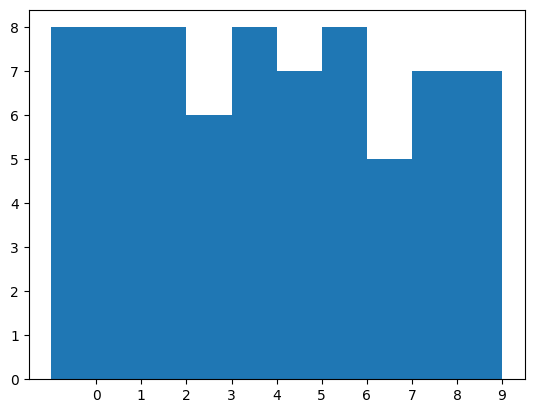

In [9]:
from collections import Counter

counter = Counter(val_generator.classes)

labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

Definindo a dimensão das imagens para acomodar imagens RGB (com 3 canais)

In [10]:
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

Criando uma model com base na CNN pré treinada MobileNet V2, desenvolvida pela Google e pré-treinada usando o dataset da ImageNet, sem a camada superior, que inclui as camadas de classificação.

In [11]:
base_model = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)


2023-10-14 10:34:02.567999: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-10-14 10:34:02.568025: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-14 10:34:02.568032: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-14 10:34:02.568091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-14 10:34:02.568124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Aplicando fine-tunning nas últimas camadas do modelo, forçando os pesos a se ajustarem äs características mais específicas do dataset.

In [12]:
base_model.trainable = True

Mostrando a quantidade de camadas no modelo.

In [13]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  707


Montando o modelo da CNN:
1. Modelo pré-treinado da MobileNet V2 com fine-tunning a partir da 100a camada;
2. Camada de Convolução com 32 filtros e ativação Relu;
3. Camada de Dropout de 20% dos nós;
4. Camada de Pooling;
5. Camada FC com 17 labels de classificação

In [14]:
model = tf.keras.Sequential([
    base_model,  # 1
    # tf.keras.layers.Conv2D(32, 3, activation='relu'),  # 2
    # tf.keras.layers.Dropout(0.2),  # 3
    tf.keras.layers.GlobalAveragePooling2D(),  # 4
    tf.keras.layers.Dense(10, activation='softmax')  # 5
])

Compilando a model

In [15]:
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.0001, momentum=0.9),  # 1
              loss='categorical_crossentropy',  # 2
              metrics=['accuracy'])  # 3
# To see the model summary in a tabular structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                19210     
                                                                 
Total params: 18341194 (69.97 MB)
Trainable params: 18112138 (69.09 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


Definindo as épocas para o treinamento da model

In [16]:
epochs = 20

Treinando a model

In [17]:
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[cp_callback])

Epoch 1/20


2023-10-14 10:34:11.023301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 2.5957 - accuracy: 0.0543

2023-10-14 10:35:29.236223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to checkpoints/cp.ckpt
22/22 [==============================] - 92s 4s/step - loss: 2.5957 - accuracy: 0.0543 - val_loss: 2.4168 - val_accuracy: 0.0833
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 2.1442 - accuracy: 0.2771
Epoch 2: saving model to checkpoints/cp.ckpt
22/22 [==============================] - 67s 3s/step - loss: 2.1442 - accuracy: 0.2771 - val_loss: 2.1158 - val_accuracy: 0.3056
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 1.7483 - accuracy: 0.5214
Epoch 3: saving model to checkpoints/cp.ckpt
22/22 [==============================] - 66s 3s/step - loss: 1.7483 - accuracy: 0.5214 - val_loss: 1.8929 - val_accuracy: 0.4028
Epoch 4/20
22/22 [==============================] - ETA: 0s - loss: 1.4206 - accuracy: 0.7229
Epoch 4: saving model to checkpoints/cp.ckpt
22/22 [==============================] - 63s 3s/step - loss: 1.4206 - accuracy: 0.7229 - val_loss: 1.6493 - val_accuracy: 0.5556
Epoch 5/20
22/22 [===

Visualizando as curvas de aprendizado

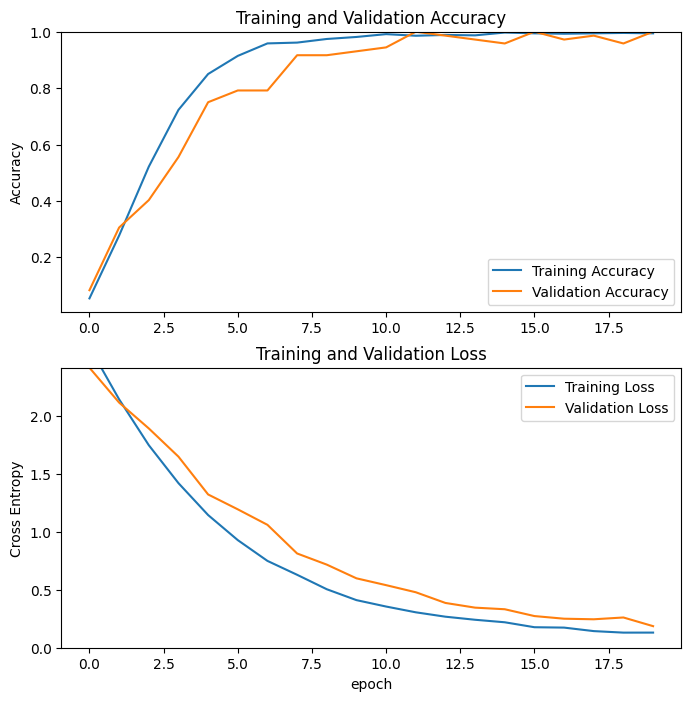

In [18]:
acc       = history.history['accuracy']
val_acc   = history.history['val_accuracy']
loss      = history.history['loss']
val_loss  = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(val_loss)])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()